In [154]:
import pandas as pd
import pandas_profiling as pdp
import matplotlib.pyplot as plt
import numpy as np

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import make_scorer, mean_squared_log_error 
from sklearn.ensemble import StackingRegressor

from xgboost.sklearn import XGBRegressor
from sklearn.utils import all_estimators

import warnings

warnings.filterwarnings("ignore")

In [155]:
data_train = pd.read_csv("train.csv")
data_test = pd.read_csv("test.csv")
data_test_ids = data_test.pop("Id")

y = data_train.pop("SalePrice") 

In [156]:
# profile = pdp.ProfileReport(data_train)
# profile.to_file("profile_start.html")

In [157]:
# Dropping columns with a high percentage of zero or NaN values
to_drop_list = ["Id", "Alley", "MasVnrArea", "BsmtFinSF1", "BsmtFinSF2", "2ndFlrSF", "LowQualFinSF", "WoodDeckSF", "OpenPorchSF", "EnclosedPorch", "3SsnPorch", "ScreenPorch", "PoolArea",
"PoolQC", "Fence", "MiscFeature", "MiscVal"]
data_train.drop(to_drop_list, axis=1, inplace=True)
data_test.drop(to_drop_list[1:], axis=1, inplace=True)

In [158]:
# Feature engineering

# data_train["TotalLot"] = data_train["LotFrontage"] * data_train["LotArea"]
# data_test["TotalLot"] = data_test["LotFrontage"] * data_test["LotArea"]

data_train["TotalQuality"] = data_train["OverallQual"] * data_train["OverallCond"]
data_test["TotalQuality"] = data_test["OverallQual"] * data_test["OverallCond"]

data_train["LastRemodel"] = data_train["YearRemodAdd"] - data_train["YearBuilt"]
data_test["LastRemodel"] = data_test["YearRemodAdd"] - data_test["YearBuilt"]

to_drop_list = ["OverallQual", "OverallCond", "YearRemodAdd"] # Drop unneeded features are they are included in the engineered features
data_train.drop(to_drop_list, axis=1, inplace=True)
data_test.drop(to_drop_list, axis=1, inplace=True)

In [159]:
data_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,GarageArea,GarageQual,GarageCond,PavedDrive,MoSold,YrSold,SaleType,SaleCondition,TotalQuality,LastRemodel
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,548,TA,TA,Y,2,2008,WD,Normal,35,0
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,460,TA,TA,Y,5,2007,WD,Normal,48,0
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,608,TA,TA,Y,9,2008,WD,Normal,35,1
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,642,TA,TA,Y,2,2006,WD,Abnorml,35,55
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,836,TA,TA,Y,12,2008,WD,Normal,40,0


In [160]:
categorical_cols = data_train.select_dtypes(["object"]).columns.tolist() # Get all columns which are categorical
print(categorical_cols)
# Fill missing values in categorical columns with that column's mode
data_train.fillna(data_train[categorical_cols].mode().iloc[0], inplace=True) 
data_test.fillna(data_test[categorical_cols].mode().iloc[0], inplace=True)

['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition']


In [161]:
cols_with_empty_train = data_train.columns[data_train.isna().any()].tolist() # Get all columns with empty values
cols_with_empty_test = data_test.columns[data_test.isna().any()].tolist() # Get all columns with empty values
# Impute missing numerical values
imputer = IterativeImputer(max_iter=20, random_state=42)
data_train[cols_with_empty_train] = imputer.fit_transform(data_train[cols_with_empty_train])
data_test[cols_with_empty_test] = imputer.fit_transform(data_test[cols_with_empty_test])

In [162]:
# Encode categorical columns with ordinal integers (dummy variables)
encoder = OrdinalEncoder()
data_train[categorical_cols] = encoder.fit_transform(data_train[categorical_cols])
data_test[categorical_cols] = encoder.fit_transform(data_test[categorical_cols])

In [163]:
data_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,GarageArea,GarageQual,GarageCond,PavedDrive,MoSold,YrSold,SaleType,SaleCondition,TotalQuality,LastRemodel
0,60,3.0,65.0,8450,1.0,3.0,3.0,0.0,4.0,0.0,...,548,4.0,4.0,2.0,2,2008,8.0,4.0,35,0
1,20,3.0,80.0,9600,1.0,3.0,3.0,0.0,2.0,0.0,...,460,4.0,4.0,2.0,5,2007,8.0,4.0,48,0
2,60,3.0,68.0,11250,1.0,0.0,3.0,0.0,4.0,0.0,...,608,4.0,4.0,2.0,9,2008,8.0,4.0,35,1
3,70,3.0,60.0,9550,1.0,0.0,3.0,0.0,0.0,0.0,...,642,4.0,4.0,2.0,2,2006,8.0,0.0,35,55
4,60,3.0,84.0,14260,1.0,0.0,3.0,0.0,2.0,0.0,...,836,4.0,4.0,2.0,12,2008,8.0,4.0,40,0


In [164]:
# def get_features_vif(values, n): # Function that returns the Variance Inflation Factor from a DataFrame
#     return [variance_inflation_factor(values, i) for i in range(n)]

In [165]:
# Show a variance inflation factor for each feature to detect the extend of multicollinearity
# n_features = data_train.shape[1]
# pd.set_option("display.max_rows", n_features)
# vif = pd.DataFrame({"features" : data_train.columns, "factor" : get_features_vif(data_train.values, n_features)}) 
# print(f"""Variance Inflation Factor
# {vif}""")

In [166]:
# def remove_highest_factor(vif, threshold): # Function to remove the highest VIF factor higher than threshold
#     high_idx = 0
#     high_val = threshold
#     for idx, row in vif.iterrows():
#         if row[1] > high_val:
#             high_idx = idx
#             high_val = row[1]
#     if high_val <= threshold:
#         return (True, vif)
#     vif.drop([high_idx], inplace=True)
#     vif.reset_index(drop=True, inplace=True)
#     new_vals = data_train[list(vif.iloc[:,0])].values
#     return (False, pd.DataFrame({"features" : vif.iloc[:,0], "factor" : get_features_vif(data_train[list(vif.iloc[:,0])].values, new_vals.shape[1])}))

In [167]:
# Let us get rid of the most correlated features, where the VIF factor > 10, in a round by round fashion until there is only features with VIF factor of under 10
# threshold = 5
# vif_t = remove_highest_factor(vif, threshold)
# while True:
#     vif_t = remove_highest_factor(vif_t[1], threshold)
#     if vif_t[0]:
#         break
# vif = vif_t[1]
# print(f"""Variance Inflation Factor
# {vif}""")

# data_train = data_train[vif.iloc[:,0]]
# data_test = data_test[vif.iloc[:,0]]

In [168]:
#mm_scaler = MinMaxScaler((0, 1))
sta_scaler = StandardScaler()

#  Standardize all columns
data_train[data_train.columns] = sta_scaler.fit_transform(data_train[data_train.columns])
data_test[data_test.columns] = sta_scaler.fit_transform(data_test[data_test.columns])

#  # Scale to range 0-1
# data_train[data_train.columns] = mm_scaler.fit_transform(data_train[data_train.columns])
# data_test[data_test.columns] = mm_scaler.fit_transform(data_test[data_test.columns])

data_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,GarageArea,GarageQual,GarageCond,PavedDrive,MoSold,YrSold,SaleType,SaleCondition,TotalQuality,LastRemodel
0,0.073375,-0.045532,-0.229249,-0.207142,0.064238,0.750731,0.314667,-0.02618,0.604670,-0.225716,...,0.351000,0.215646,0.186019,0.289745,-1.599111,0.138777,0.313867,0.208502,0.123216,-0.555742
1,-0.872563,-0.045532,0.451909,-0.091886,0.064238,0.750731,0.314667,-0.02618,-0.628316,-0.225716,...,-0.060731,0.215646,0.186019,0.289745,-0.489110,-0.614439,0.313867,0.208502,1.533735,-0.555742
2,0.073375,-0.045532,-0.093018,0.073480,0.064238,-1.378933,0.314667,-0.02618,0.604670,-0.225716,...,0.631726,0.215646,0.186019,0.289745,0.990891,0.138777,0.313867,0.208502,0.123216,-0.514873
3,0.309859,-0.045532,-0.456302,-0.096897,0.064238,-1.378933,0.314667,-0.02618,-1.861302,-0.225716,...,0.790804,0.215646,0.186019,0.289745,-1.599111,-1.367655,0.313867,-3.426284,0.123216,1.692084
4,0.073375,-0.045532,0.633551,0.375148,0.064238,-1.378933,0.314667,-0.02618,-0.628316,-0.225716,...,1.698485,0.215646,0.186019,0.289745,2.100892,0.138777,0.313867,0.208502,0.665723,-0.555742


In [169]:
data_test.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,GarageArea,GarageQual,GarageCond,PavedDrive,MoSold,YrSold,SaleType,SaleCondition,TotalQuality,LastRemodel
0,-0.874711,-1.501777,0.536804,0.363929,0.06426,0.742620,0.31870,0.0,0.572445,-0.207992,...,1.186066,0.250409,0.186902,0.339114,-0.038281,1.713905,0.32475,0.201383,-0.394200,-0.520737
1,-0.874711,-0.039098,0.584770,0.897861,0.06426,-1.384637,0.31870,0.0,-1.950811,-0.207992,...,-0.741065,0.250409,0.186902,0.339114,-0.038281,1.713905,0.32475,0.201383,0.261477,-0.520737
2,0.061351,-0.039098,0.249010,0.809646,0.06426,-1.384637,0.31870,0.0,0.572445,-0.207992,...,0.042696,0.250409,0.186902,0.339114,-1.140614,1.713905,0.32475,0.201383,-0.940597,-0.478418
3,0.061351,-0.039098,0.440873,0.032064,0.06426,-1.384637,0.31870,0.0,0.572445,-0.207992,...,-0.012628,0.250409,0.186902,0.339114,-0.038281,1.713905,0.32475,0.201383,0.261477,-0.520737
4,1.465443,-0.039098,-1.237924,-0.971808,0.06426,-1.384637,-2.53396,0.0,0.572445,-0.207992,...,0.153345,0.250409,0.186902,0.339114,-1.875504,1.713905,0.32475,0.201383,0.698594,-0.520737


In [170]:
pca = PCA(n_components=3)
data_train_pca = pca.fit_transform(data_train)
data_test_pca = pca.fit_transform(data_test)

data_train_processed = data_train.copy()
data_test_processed = data_test.copy()

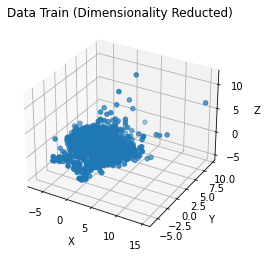

In [171]:
# Plot our data which been scaled and dimensionality reducted to detect possible outliers
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(data_train_pca[:,0], data_train_pca[:,1], data_train_pca[:,2]) 
plt.title("Data Train (Dimensionality Reducted)")
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

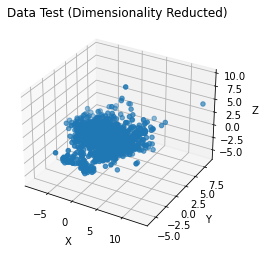

In [172]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(data_test_pca[:,0], data_test_pca[:,1], data_test_pca[:,2]) 
plt.title("Data Test (Dimensionality Reducted)")
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

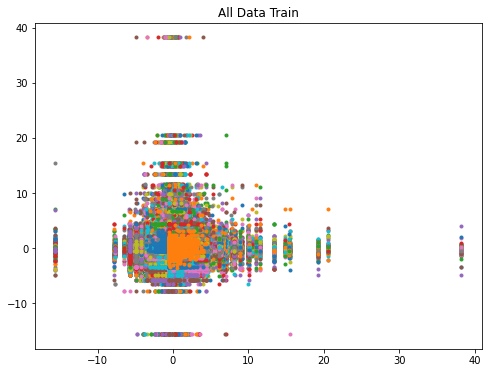

In [143]:
_, n_features = data_train_processed.shape
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot()
plt.title("All Data Train")
for i in range(n_features):
    for j in range(n_features):
        if i == j:
            continue
        ax.scatter(data_train_processed.iloc[:,i], data_train_processed.iloc[:,j], marker=".")
plt.show()


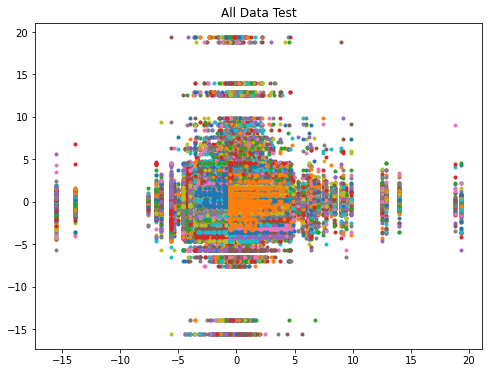

In [144]:
_, n_features = data_test_processed.shape
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot()
plt.title("All Data Test")
for i in range(n_features):
    for j in range(n_features):
        if i == j:
            continue
        ax.scatter(data_test_processed.iloc[:,i], data_test_processed.iloc[:,j], marker=".")
plt.show()

In [145]:
# profile = pdp.ProfileReport(data_train_processed)
# profile.to_file("profile_end.html")

Export report to file: 100%|██████████| 1/1 [00:00<00:00,  6.41it/s]


In [146]:
X_train, X_test, y_train, y_test = train_test_split(data_train_processed, y, test_size=0.3)

In [147]:
def MSLE(y, y_pred):
    return mean_squared_log_error(y, y_pred)

In [148]:
def RMSLE(y, y_pred): # Root Mean Squared Log Error
    return np.sqrt(MSLE(y, y_pred))

In [149]:
estimators_all = all_estimators(type_filter="regressor") # Get all regressor estimators from sklearn library
est_tuples = [] # Estimators we're going to test and other information
for name, RegressorClass in estimators_all:
    try:
        #print(name)
        est_tuples.append([name, RegressorClass(), 0])
    except Exception as e:
        pass # Ignore all estimators which need a init parameter
est_tuples.append(["XGBoostRegressor", XGBRegressor(), 0]) # Add XGBoost regressor which is not in the default sklearn library

for est in est_tuples:
    try:
        est[1].fit(X_train, y_train)
        est[2] = RMSLE(y_test, est[1].predict(X_test))
    except Exception as e:
        pass

est_tuples = [x for x in est_tuples if x[2] > 0] # Purge every regressor with a score of 0
est_tuples = sorted(est_tuples, key=lambda x: x[2])
print(f"""Best Regressor: {est_tuples[0][0]} 
RMSLE Score: {est_tuples[0][2]}""")

Best Regressor: GradientBoostingRegressor 
RMSE Score: 0.12487516018197867


In [150]:
# Tune hyper-parameters for the regressor we chose
param_grid = {
    "loss" : ["huber"],
    "learning_rate" : [0.0001, 0.001, 0.0025, 0.005],
    "n_estimators" : [10000]
}

cv = KFold(n_splits=5, shuffle=True, random_state=23)
scorer = make_scorer(RMSLE, greater_is_better=False)
grid_search = GridSearchCV(est_tuples[0][1], param_grid=param_grid, scoring=scorer, n_jobs=-1, cv=cv)
grid_search.fit(data_train_processed, y)
print(grid_search.best_params_)

{'learning_rate': 0.005, 'loss': 'huber', 'n_estimators': 10000}


In [151]:
reg_final = est_tuples[0][1] # Our final regressor
reg_final.set_params(**grid_search.best_params_)
reg_final.fit(data_train_processed, y)

GradientBoostingRegressor(learning_rate=0.005, loss='huber', n_estimators=10000)

In [173]:
prediction = reg_final.predict(data_test_processed)
result = pd.DataFrame({"Id" : data_test_ids, "SalePrice" : prediction})
result.head()

,Id,SalePrice
0,1461,125364.316129
1,1462,167865.256346
2,1463,183101.893711
3,1464,186878.403436
4,1465,183546.128273


In [174]:
result.to_csv("result.csv", index=False)